# Model: 2CNN + LSTM + Attention
Adapted from https://github.com/xuanjihe/speech-emotion-recognition/blob/master/model.py

Mingyi Chen, Xuanji He, Jing Yang, Han Zhang, "3-D Convolutional Recurrent Neural Networks With Attention Model for Speech Emotion Recognition", IEEE Signal Processing Letters, vol. 25, no. 10, pp. 1440-1444, 2018.

# Prepare data for training

In [1]:
# Load data
import numpy as np
import os
from google.colab import drive

drive.mount('/content/drive')
%cd "drive/My Drive/ptsa"

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# Drop neutral class because of class imbalance
X_train = X_train[np.where(y_train != 0)]
y_train = y_train[np.where(y_train != 0)]
X_test = X_test[np.where(y_test != 0)]
y_test = y_test[np.where(y_test != 0)]
# Subtract one for emotion label
y_train = np.array([i-1 for i in y_train])
y_test = np.array([i-1 for i in y_test])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/ptsa


In [2]:
import sys
sys.path.append('/content/drive/My Drive/ptsa')
import utils

# Count number of samples
dataset_size = X_train.shape[0]
valid_size = X_test.shape[0]

# Convert label to vector form
y_train = utils.dense_to_one_hot(y_train, 7)
y_test = utils.dense_to_one_hot(y_test, 7)

# Training

In [0]:
from __future__ import absolute_import
from __future__ import division
import tensorflow as tf
from sklearn.metrics import recall_score as accuracy_score
from sklearn.metrics import confusion_matrix as confusion

# Set parameters
tf.app.flags.DEFINE_integer('num_epoch', 5000, 'The number of epoches for training.')
tf.app.flags.DEFINE_integer('num_classes', 7, 'The number of emotion classes.')
tf.app.flags.DEFINE_integer('batch_size', 60, 'The number of samples in each batch.')
tf.app.flags.DEFINE_boolean('is_adam', True,'whether to use adam optimizer.')
tf.app.flags.DEFINE_float('learning_rate', 0.00001, 'learning rate of Adam optimizer')
tf.app.flags.DEFINE_float('dropout_keep_prob', 1,  'the prob of every unit keep in dropout layer')
tf.app.flags.DEFINE_integer('image_height', 300, 'image height')
tf.app.flags.DEFINE_integer('image_width', 40, 'image width')
tf.app.flags.DEFINE_integer('image_channel', 3, 'image channels as input')
tf.app.flags.DEFINE_string  ('checkpoint', './checkpoint/', 'the checkpoint dir')
tf.app.flags.DEFINE_string  ('model_name', 'best_model.ckpt', 'model name')
FLAGS = tf.app.flags.FLAGS

In [0]:
from model import acrnn
tf.reset_default_graph()
def train(X_train, y_train, X_test, y_test):
    # Create placeholders
    X = tf.placeholder(tf.float32, shape=[None, 
                                          FLAGS['image_height'].value,
                                          FLAGS['image_width'].value,
                                          FLAGS['image_channel'].value])
    Y = tf.placeholder(tf.int32, shape=[None, FLAGS['num_classes'].value])
    is_training = tf.placeholder(tf.bool)
    lr = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)
    Ylogits = acrnn(X, is_training=is_training, dropout_keep_prob=keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels =  Y, logits =  Ylogits)
    cost = tf.reduce_mean(cross_entropy)
    var_trainable_op = tf.trainable_variables()

    # Set optimizer
    train_op = tf.train.AdamOptimizer(lr).minimize(cost)

    # Set metrics
    correct_pred = tf.equal(tf.argmax(Ylogits, 1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    saver=tf.train.Saver(tf.global_variables())
    init = tf.global_variables_initializer()

    # Training
    best_acc_val = 0
    # Keep track of loss/acc history
    cost_train_hist = []
    acc_train_hist = []
    cost_val_hist = []
    acc_val_hist = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(FLAGS['num_epoch'].value):
            # Train         
            start = (i * FLAGS['batch_size'].value) % len(X_train)
            end = min(start+FLAGS['batch_size'].value, len(X_train))
            [_,cost_train,acc_train] = sess.run([train_op,cost,accuracy], 
                                                feed_dict={X:X_train[start:end,:,:,:], Y:y_train[start:end,:],
                                                is_training:True, keep_prob:FLAGS['dropout_keep_prob'].value, lr:FLAGS['learning_rate'].value})
            if i % 10 == 0:
                # Evaluation
                val_iter = divmod((len(X_test)), FLAGS['batch_size'].value)[0]
                y_pred = np.empty((len(X_test), FLAGS['num_classes'].value), dtype=np.float32)
                cost_val= 0
                if (len(X_test) < FLAGS['batch_size'].value):
                    loss, y_pred = sess.run([cross_entropy,Ylogits],feed_dict = {X:X_test, Y:y_test,is_training:False, keep_prob:1})
                    cost_val = cost_val + np.sum(loss)
                for v in range(val_iter):
                    v_begin = v * FLAGS['batch_size'].value
                    v_end = (v+1) * FLAGS['batch_size'].value
                    if(v == val_iter-1):
                        if(v_end < len(X_test)):
                            v_end = len(X_test)
                    loss, y_pred[v_begin:v_end,:] = sess.run([cross_entropy,Ylogits],feed_dict = {X:X_test[v_begin:v_end], Y:y_test[v_begin:v_end],is_training:False, keep_prob:1})
                    cost_val = cost_val + np.sum(loss)
                cost_val = cost_val/len(X_test)
                acc_val = accuracy_score(np.argmax(y_test,1), np.argmax(y_pred, 1),average='macro')
                conf_val = confusion(np.argmax(y_test, 1), np.argmax(y_pred, 1))
                cost_val_hist.append(cost_val)
                acc_val_hist.append(acc_val)
                cost_train_hist.append(cost_train)
                acc_train_hist.append(acc_train)
                if acc_val > best_acc_val:
                    best_acc_val = acc_val
                    best_conf_val = conf_val
                    saver.save(sess, os.path.join(FLAGS['checkpoint'].value, FLAGS['model_name'].value), global_step = i+1)
                print ("---------------------------------------")
                print ("Epoch: %05d" %(i+1))
                print ("Training cost: %2.3g" % cost_train)   
                print ("Training accuracy: %3.4g" % acc_train) 
                print ("Valid cost: %2.3g" % cost_val)
                print ("Valid accuracy: %3.4g" % acc_val)    
                print ("Best valid accuracy: %3.4g" % best_acc_val) 
                print ()
    return cost_train_hist, acc_train_hist, cost_val_hist, acc_val_hist, best_conf_val

In [34]:
cost_train_hist, acc_train_hist, cost_val_hist, acc_val_hist, best_conf_val = train(X_train, y_train, X_test, y_test)

---------------------------------------
Epoch: 00001
Training cost: 1.96
Training accuracy: 0.1333
Valid cost: 1.96
Valid accuracy: 0.1488
Best valid accuracy: 0.1488

---------------------------------------
Epoch: 00011
Training cost: 1.94
Training accuracy: 0.15
Valid cost: 1.93
Valid accuracy: 0.1875
Best valid accuracy: 0.1875

---------------------------------------
Epoch: 00021
Training cost: 1.89
Training accuracy: 0.3333
Valid cost: 1.91
Valid accuracy: 0.247
Best valid accuracy: 0.247

---------------------------------------
Epoch: 00031
Training cost: 1.92
Training accuracy: 0.1833
Valid cost: 1.89
Valid accuracy: 0.2649
Best valid accuracy: 0.2649

---------------------------------------
Epoch: 00041
Training cost: 1.88
Training accuracy: 0.25
Valid cost: 1.87
Valid accuracy: 0.2679
Best valid accuracy: 0.2679

---------------------------------------
Epoch: 00051
Training cost: 1.85
Training accuracy: 0.25
Valid cost: 1.86
Valid accuracy: 0.2619
Best valid accuracy: 0.2679



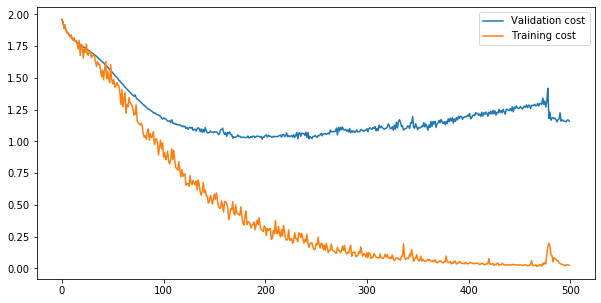

In [35]:
# Plot cost
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(cost_val_hist, label = "Validation cost")
plt.plot(cost_train_hist, label = "Training cost")
plt.legend()
plt.show()

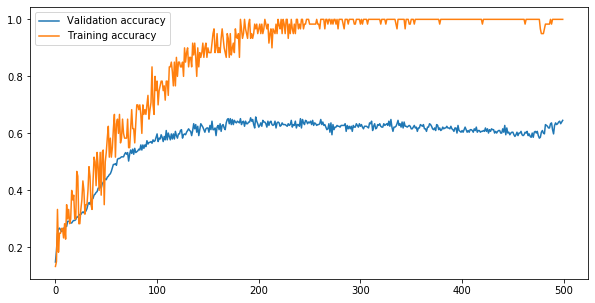

In [36]:
plt.figure(figsize=(10,5))
plt.plot(acc_val_hist, label = "Validation accuracy")
plt.plot(acc_train_hist, label = "Training accuracy")
plt.legend()
plt.show()

In [55]:
# Confusion matrix
# Row: actual label
# Column: predicted label
import pandas as pd
meta_df = pd.read_csv("meta_data.csv")
label = list(meta_df[["emotion", "emotion_str"]].drop_duplicates().loc[1:,"emotion_str"])
confusion_matrix = pd.DataFrame(best_conf_val, columns = label, index = label)
confusion_matrix["accuracy"] = [confusion_matrix.iloc[i, i]/np.sum(confusion_matrix.iloc[i, :]) for i in range(len(confusion_matrix))]
confusion_matrix

,calm,happy,sad,fearful,angry,disgust,surprise,accuracy
calm,36,0,11,0,0,0,1,0.750000
happy,0,27,8,2,6,0,5,0.562500
sad,12,6,24,0,1,2,3,0.500000
fearful,1,1,1,36,1,6,2,0.750000
angry,2,5,4,1,31,0,5,0.645833
disgust,4,2,1,3,2,35,1,0.729167
surprise,2,3,5,2,2,2,32,0.666667
